# Google News Recommendations

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
import random
from scipy.stats import norm

In [0]:
def random_argmax(rng, list_):
    """ similar to np.argmax but return a random element among max
        when multiple max exists."""
    return rng.choice(np.argwhere(list_ == list_.max()).flatten())

In [0]:
np.set_printoptions(precision=2)

## Environment



In [0]:
class Users:
    """
        Google News Users Class. 
        Init input :
            n_sources : int, Number of different sources (news website)
            n_themes : int, Number of different themes (7 at the moment on Google News)
            n_users : int, Number of Users
        Attributes :
            all of the above
            self.users_data : list, [preferences_sources, preferences_themes, next_log]
    """
    def __init__(self, n_themes, n_sources, n_users):
        self.n_users = n_users
        self.n_themes = n_themes
        self.n_sources = n_sources

        self.users_data = None

        #Call Maker function
        self.make_users_data()

    def make_users_data(self):
        """
            Makes up Data on every users.
            Each users_data is made of :
                preferences_sources : np.array(self.n_users, self.n_sources), stochastic vector 
                                     embedding user's preferences in regard to an article's theme
                preferences_themes : np.array(self.n_users, self.n_sources), stochastic vector 
                                     embedding user's preferences in regard to an article's source 
                next_log : int, in how many days will it be before the user next log

            Returns Nothing.
            Updates self.users_data.
        """
        ##Sources (Uniform for maximum entropy, continuous)
        preferences_sources = np.random.rand(self.n_users, self.n_sources)
        preferences_sources = preferences_sources / preferences_sources.sum(axis=1)[:,None]

        ##Themes (Uniform for maximum entropy, discrete (0-1))
        preferences_themes = np.random.randint(0, 2, size=(self.n_users, self.n_themes))
        #Stochastic Vector (normalizing)
        preferences_themes = preferences_themes / preferences_themes.sum(axis=1)[:,None]

        ##Next Log
        #On the first iteration, every user will log in the next day
        next_log = np.ones((self.n_users, 1))

        ##Save up everything
        self.users_data = [preferences_themes, preferences_sources, next_log]

    def set_next_log(self, index_user, next_log_i):
        self.users_data[2][index_user] = next_log_i

In [0]:
class Items:
    """
        Google News Items (articles) Class.
        Init Input :
            n_exp : int, Experience Span (in days)
            n_articles : int, Number of articles per day
            n_sources : int, Number of different sources (news website)
            n_themes : int, Number of different themes (7 at the moment on Google news)
        Attributes :
            all of the above 
            self.articles : np.array(size=(3, n_exp, n_articles)), [source, theme, hours]
    """
    def __init__(self, n_exp, n_articles, n_themes, n_sources):
        self.n_exp = n_exp
        self.n_articles = n_articles
        self.n_themes = n_themes
        self.n_sources = n_sources
        self.articles = None
        
        #Call maker function
        self.make_articles()

    def make_articles(self):
        """
            Makes up every articles on the whole experience span.
            Within a single day, there are n_articles articles. Each article is made of :
                hour : int 0-23, Hour at which the article is published
                theme : int 0-(n_themes-1), Index of the theme the article belongs to
                source : int 0-(n_sources-1), Index of the source the article comes from
            Returns Nothing.
            Updates self.articles. Expected dimension : (3, n_exp, n_articles)
        """
        ##Themes
        #To each day its headline; each day a theme is prevailing over the others
        headlines = np.asarray([np.random.randint(0, self.n_themes, self.n_articles)] * self.n_exp)
        #Centered on the headline, Normal draw themes for each article of each day
        themes = np.random.normal(loc=headlines, scale=1.0, size=(self.n_exp, self.n_articles))
        #Make draws positive then rounding them 
        themes = np.round(np.abs(themes)).astype(int)
        np.clip(themes, 0, self.n_themes-1, out=themes)

        ##Sources
        sources = np.random.randint(0, self.n_sources, size=(self.n_exp, self.n_articles))

        ##Date
        days = np.arange(self.n_exp)
        days = np.tile(days, (100, 1)).T
        ##Save up Everything
        self.articles = np.asarray([sources, themes, days])

In [0]:
class GoogleNewsEnv:
    """ 
        Explicit Feedback for Google News.
    """
    def __init__(self, 
                 n_exp=30, 
                 n_articles=100, 
                 n_themes=7, 
                 n_sources=7,
                 n_users=5,
                 tau=72,
                 seed=None):
        
        self.n_exp = n_exp
        self.n_articles = n_articles
        self.n_themes = n_themes
        self.n_sources = n_sources
        self.n_users = n_users
        self.date = 0
        self.tau = tau
        self.users = Users(self.n_themes, self.n_sources, self.n_users)
        self.items = Items(self.n_exp, n_articles, self.n_themes, self.n_sources)   
        
        self._rng = np.random.RandomState(seed) 
        self.next_logs = None
        self.hours_users_loggedin = None
        self.index_users_loggedin = np.argwhere(self.users.users_data[2] == 0)
        self.done = False
        self._next_state()
                

    def step(self, action):
        # check if behind done
        if self.done: #self.date >= self.n_exp:
            print("You are calling step after it return done=True.\n"
                  "You should reset the environment.")

        self.action = action

        # compute potential rewards
        potential_rewards = self.compute_best_reward()
        optimal_return = np.max(potential_rewards)

        # compute reward associated with action
        self.reward = self.compute_reward(action)

        # when will the users will come back
        self.update_next_logs()
        
        # check if done
        if self.date == self.n_exp:
            self.done = True

        # compute next state S_{t+1}
        self._next_state()

        return self.reward, self.state, self.done, optimal_return

    def update_next_logs(self):
        for index_user, _ in enumerate(self.index_users_loggedin):
            self.users.set_next_log(index_user, self.next_logs[index_user])

    def compute_reward(self, action):        
        lambdas_list = []
        k = 0
        for index_user in self.index_users_loggedin:
            for coords in action.T:
                lambda_temp = 1 + 5 * self.users.users_data[0][index_user][self.state[0][coords[0]][coords[1]]]
                lambda_temp += 5 * self.users.users_data[1][index_user][self.state[1][coords[0]][coords[1]]]
                lambda_temp *= 10 * (1 - np.exp(- np.random.randint(23) / self.tau))
                lambdas_list.append(lambda_temp)

        next_logs = np.random.poisson(np.round(np.asarray(lambdas_list).astype(np.float64), decimals=5),  size=(1, len(lambdas_list)))
        self.next_logs = next_logs.reshape(-1)

        reward = 1 / (next_logs.sum() + 1)**2
        return reward

    def compute_best_reward(self):
        best_logs = []
        return 1 
        for index_user in self.index_users_loggedin:
            lambda_list_temp = []
            for j in range(env.state.shape[1]):
                for k in range(env.state.shape[2]):
                    lambda_temp = 1 + 5 * self.users.users_data[0][index_user][self.state[0][j][k]]
                    lambda_temp += 5 * self.users.users_data[1][index_user][self.state[1][j][k]]
                    lambda_temp *= 10 * (1 - np.exp(- np.random.randint(23) / self.tau))
                    lambda_list_temp.append(lambda_temp)
            next_logs_temp = np.random.poisson(np.round(np.asarray(lambda_list_temp).astype(np.float64), decimals=2),  size=(1, len(lambda_list_temp)))
            best_logs.append(min(next_logs_temp, 0))
            print(min(next_logs_temp))

        reward = 1
        return reward

    def reset(self, seed=None):
        self._rng = np.random.RandomState(seed)
        self.date = 0
        self.done = False

        self.users = Users(self.n_themes, self.n_sources, self.n_users)
        self.items = Items(self.n_exp, self.n_articles, self.n_themes, self.n_sources)

        self._next_state()
        return self.state

    def _next_state(self):
        #Time flies
        self.date += 1
        self.users.users_data[2] = self.users.users_data[2] - 1

        #Which users are logging in ?
        self.index_users_loggedin = np.argwhere(self.users.users_data[2] == 0)[:, 0]

        #We consider articles from a 3 - day span
        lower_bound = max(0, self.date - 3)
        context = self.items.articles[:, lower_bound:self.date, :]
        self.state = context

In [0]:
env = GoogleNewsEnv()

In [0]:
##############################################
#CONTEXTE : Tous les articles disponibles pour chacun des 5 users [source, theme, hours]
print(env.state)
print(len(env.state))

## Agent

In [0]:
class Random:
    """ Random agent. """
    def __init__(self, nb_arms, seed=None):
        self._nb_arms = nb_arms
        self._rng = np.random.RandomState(seed)
        
    def act(self, context, nb_tirages):
        actions_j = self._rng.randint(context.shape[1], size = (1, nb_tirages)) # note that action size is changing
        actions_k = self._rng.randint(context.shape[2], size = (1, nb_tirages))
        actions = np.concatenate((actions_j, actions_k))
        return actions
        
    def update(self, context, action, reward):
        pass

In [0]:
agent = Random(None, seed=2020)

In [0]:
class EpsilonGreedy:
    """ Epsilon greedy agent. """
    def __init__(self, context, epsilon=0, seed=None):
        self._epsilon = epsilon
        self._rng = np.random.RandomState(seed)
        self._q = np.zeros(size=context.shape)
        self._n = np.zeros(size=context.shape)

    def act(self, context):
        if self._rng.rand() < self._epsilon:
            actions_j = self._rng.randint(context.shape[1], size = (1, nb_tirages)) # note that action size is changing
            actions_k = self._rng.randint(context.shape[2], size = (1, nb_tirages))
            actions = np.concatenate((actions_j, actions_k))
        else:
            action = random_argmax(self._rng, self._q)
        return action

    def update(self,context, action, reward):
        self._n[action] += 1
        self._q[action] += (reward - self._q[action])/self._n[action]

## Run experiment

In [0]:
def run_exp(agent, env, nb_steps, env_seed):
    rewards = np.zeros(nb_steps)
    regrets = np.zeros(nb_steps)
    actions = np.zeros(nb_steps)
    context = env.reset(env_seed)
    nb_tirages = env.index_users_loggedin.shape[0]
    for i in range(nb_steps):
        # Select action from agent policy.
        action = agent.act(context, nb_tirages)
        
        # Play action in the environment and get reward.
        reward, next_context, done, optimal_return = env.step(action)
        
        # Update history
        rating = reward
        
        # Update agent.
        agent.update(context, action, reward)
        context = next_context
        nb_tirages = env.index_users_loggedin.shape[0]
        
        # Save history.
        #context[i] = context
        rewards[i] = reward
        regrets[i] = optimal_return - reward

    reward = rewards.sum()
    regret = np.sum(regrets)
    return {'reward': reward, 
            'regret': regret,
            'rewards': rewards,
            'regrets': regrets,
            'cum_rewards': np.cumsum(rewards), 
            'cum_regrets': np.cumsum(regrets)
            }


#### Example
Let's run our previous agent and environment 100 times.

In [101]:
env = GoogleNewsEnv()
run_exp(agent, env, nb_steps=15, env_seed=2020)

{'cum_regrets': array([1.  , 1.  , 1.  , 1.  , 1.  , 2.  , 2.  , 2.  , 2.  , 2.  , 2.  ,
        2.93, 2.93, 2.93, 2.93]),
 'cum_rewards': array([2.69e-04, 1.00e+00, 2.00e+00, 3.00e+00, 4.00e+00, 4.00e+00,
        5.00e+00, 6.00e+00, 7.00e+00, 8.00e+00, 9.00e+00, 9.07e+00,
        1.01e+01, 1.11e+01, 1.21e+01]),
 'regret': 2.9337710474265113,
 'regrets': array([1.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.94, 0.  , 0.  , 0.  ]),
 'reward': 12.06622895257349,
 'rewards': array([2.69e-04, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 3.46e-03,
        1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 1.00e+00, 6.25e-02,
        1.00e+00, 1.00e+00, 1.00e+00])}

In [103]:
nb_exp = 15
nb_steps = 15
regret = np.zeros(nb_exp)
regrets = np.zeros((nb_exp, nb_steps))
for i in range(nb_exp):
    env = GoogleNewsEnv()
    agent = Random(None, seed=i)
    exp = run_exp(agent, env, nb_steps, env_seed=i)
    regret[i] = exp['regret'] 
    regrets[i] = exp['cum_regrets']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide


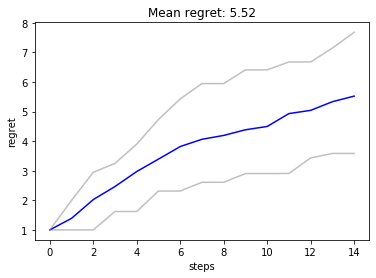

In [104]:
plt.plot(regrets.mean(axis=0), color='blue')
plt.plot(np.quantile(regrets, 0.05,axis=0), color='grey', alpha=0.5)
plt.plot(np.quantile(regrets, 0.95,axis=0), color='grey', alpha=0.5)
plt.title('Mean regret: {:.2f}'.format(regret.mean()))
plt.xlabel('steps')
plt.ylabel('regret')
plt.show()